# Reading health data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import seaborn as sns
import matplotlib.pyplot as plt

# SparkSession is the entry point to Spark SQL.
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('HealthcarePrediction')\
        .getOrCreate()


# A SQLContext can be used create DataFrame, 
# register DataFrame as tables, 
# execute SQL over tables, 
# cache tables, and 
# read parquet files.
sqlContext = SQLContext(spark.sparkContext)

In [2]:
# Reading CSV file
csv_file = 'HealthData.csv'
df_health = spark.read.csv(csv_file, inferSchema=True, header=True, mode='DROPMALFORMED')

# Exploring the dataset

In [3]:
#Spark schema is the structure of the DataFrame or Dataset, we can define it using StructType
df_health.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [4]:
df_health.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             41938|          30108|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390004545|       

In [5]:
# Returns the schema of the data frame.
df_health.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [6]:
# Top 5 data
df_health.head(5)

[Row(id=30669, gender='Male', age=3.0, hypertension=0, heart_disease=0, ever_married='No', work_type='children', Residence_type='Rural', avg_glucose_level=95.12, bmi=18.0, smoking_status=None, stroke=0),
 Row(id=30468, gender='Male', age=58.0, hypertension=1, heart_disease=0, ever_married='Yes', work_type='Private', Residence_type='Urban', avg_glucose_level=87.96, bmi=39.2, smoking_status='never smoked', stroke=0),
 Row(id=16523, gender='Female', age=8.0, hypertension=0, heart_disease=0, ever_married='No', work_type='Private', Residence_type='Urban', avg_glucose_level=110.89, bmi=17.6, smoking_status=None, stroke=0),
 Row(id=56543, gender='Female', age=70.0, hypertension=0, heart_disease=0, ever_married='Yes', work_type='Private', Residence_type='Rural', avg_glucose_level=69.04, bmi=35.9, smoking_status='formerly smoked', stroke=0),
 Row(id=46136, gender='Male', age=14.0, hypertension=0, heart_disease=0, ever_married='No', work_type='Never_worked', Residence_type='Rural', avg_glucose_l

In [7]:
df_health.toPandas().head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,None,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,None,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,None,0


# Looking at target distribution

In [8]:
df_health.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



# Data visualization

Text(0.5, 1.0, 'Correlation Factors Heat Map')

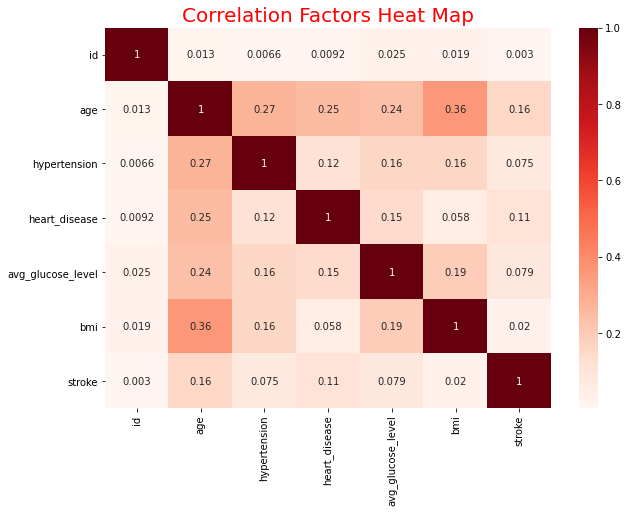

In [9]:
# Converting dataframe to pandas to get sns heatmap
pdata = df_health.toPandas()

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

sns.heatmap(
    pdata.corr(),
    annot=True ,
    cmap='Reds'
).set_title('Correlation Factors Heat Map', color='red', size='20')

# Feature Analysis

In [10]:
df_health.createOrReplaceTempView('table')

## Work Type

In [11]:
# sql query to find the number of people in specific work_type who have had stroke and not
spark.sql("""
    SELECT work_type, COUNT(work_type) as work_type_count 
    FROM table WHERE stroke == 1 
    GROUP BY work_type 
    ORDER BY COUNT(work_type) DESC;
""").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            441|
|Self-employed|            251|
|     Govt_job|             89|
|     children|              2|
+-------------+---------------+



In [12]:
spark.sql("""
    SELECT work_type, COUNT(work_type) as work_type_count 
    FROM table WHERE stroke == 0 
    GROUP BY work_type 
    ORDER BY COUNT(work_type) DESC;
""").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|          24393|
|Self-employed|           6542|
|     children|           6154|
|     Govt_job|           5351|
| Never_worked|            177|
+-------------+---------------+



## Gender

In [13]:
spark.sql("""
    SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(
        SELECT COUNT(gender) FROM table 
        WHERE gender == 'Male'
    ) as percentage 
    FROM table WHERE stroke == 1 AND gender = 'Male' 
    GROUP BY gender;
""").show()

+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|  Male|         352|1.9860076732114647|
+------+------------+------------------+



In [14]:
spark.sql("""
    SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(
        SELECT COUNT(gender) FROM table 
        WHERE gender == 'Female'
    ) as percentage 
    FROM table WHERE stroke == 1 AND gender = 'Female' 
    GROUP BY gender;
""").show()

+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|Female|         431|1.6793298266121177|
+------+------------+------------------+



## Age

In [15]:
spark.sql("""
    SELECT COUNT(age)*100/(
        SELECT COUNT(age) FROM table 
        WHERE stroke ==1
    ) as percentage 
    FROM table 
    WHERE stroke == 1 AND age>=50;
""").show()

+-----------------+
|       percentage|
+-----------------+
|91.57088122605364|
+-----------------+



# Cleaning data

In [16]:
df_health.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             41938|          30108|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390004545|       

1. Few missing values in smoking_status(30108) and bmi(41938) column.
2. Also there are few categorical data (gender, ever_married, work_type, Residence_type, smoking_status which we need to covert into one hot encoding


In [17]:
df_health = df_health.na.fill('No Info', subset=['smoking_status'])

In [18]:
from pyspark.sql.functions import mean

mean = df_health.select(mean(df_health['bmi'])).collect()
mean_bmi = mean[0][0]
df_health = df_health.na.fill(mean_bmi,['bmi'])

In [19]:
df_health.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             43400|         43400|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390005145|          n

### StringIndexer -> OneHotEncoder -> VectorAssembler

In [20]:
# indexing all categorical columns in the dataset
from pyspark.ml.feature import StringIndexer

indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")


In [21]:
# Doing one hot encoding of indexed data
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

In [22]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')


# Decision tree classifier

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')

In [24]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, dtc])

## Splitting the dataset into train and test

In [25]:
train_data,test_data = df_health.randomSplit([0.7,0.3])

## Training the model

In [26]:
# training model pipeline with data
model = pipeline.fit(train_data)

## Now we will evaluate the model with testing data

In [27]:
dtc_predictions = model.transform(test_data)

# Select example rows to display.
dtc_predictions.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.99219740177439...|     0|(16,[1,2,5,6,11,1...|
|       0.0|[0.99219740177439...|     0|(16,[1,2,5,9,10,1...|
|       0.0|[0.99219740177439...|     0|(16,[1,2,8,11,12,...|
|       0.0|[0.92255125284738...|     0|(16,[0,2,4,5,7,11...|
|       0.0|[0.99219740177439...|     0|(16,[1,2,3,5,6,11...|
+----------+--------------------+------+--------------------+
only showing top 5 rows



In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

A Decision Tree algorithm had an accuracy of: 98.12%
